# Fine-Tuning with Semantic Segmentation

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install torchinfo
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-uu1tx3fq
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-uu1tx3fq
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torchinfo
import segmentation_models_pytorch as smp
from transformers import get_linear_schedule_with_warmup

In [3]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


In [4]:
!nvidia-smi

Sun Apr  2 15:39:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# prepare data
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/img.npy.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/label.npy.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/size.npy.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/img.npy.zip
replace img.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: img.npy                 
Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/label.npy.zip
replace label.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: label.npy               
Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/size.npy.zip
replace size.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: size.npy                


In [7]:
test_img = np.load('img.npy')
print(test_img.shape)

test_label = np.load('label.npy')
print(test_label.shape)

test_size = np.load('size.npy')
print(test_size.shape)

(7390, 256, 256, 3)
(7390, 256, 256)
(7390, 2)


In [ ]:
np.unique(test_label)

In [8]:
test_label[test_label==1] = 0
test_label[test_label==2] = 1
test_label[test_label==3] = 2

np.unique(test_label)

array([0, 1, 2], dtype=uint8)

[256 170]


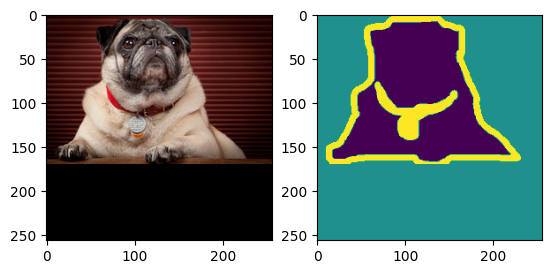

In [9]:
_, ax = plt.subplots(nrows = 1,ncols = 2)
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1])
print(test_size[0])

## Generate Padding Masks

In [10]:
test_mask = np.zeros_like(test_img[:,:,:,0])
for i in range(len(test_img)):
  test_mask[i,0:test_size[i,0],0:test_size[i,1]] = 1

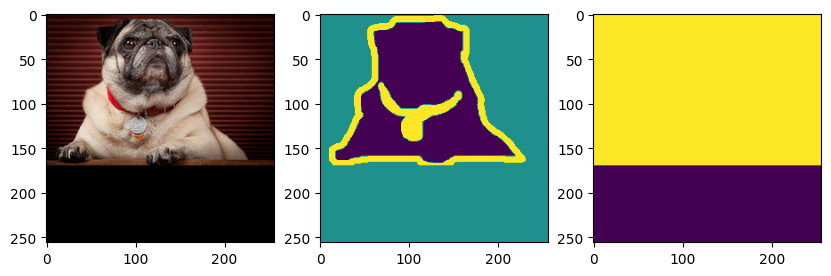

In [11]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1].astype(int))
ax[2].imshow(test_mask[1]*255.)

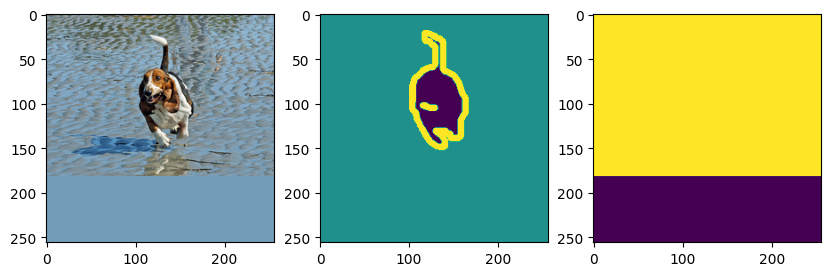

In [12]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
ax[0].imshow(test_img[13])
ax[1].imshow(test_label[13].astype(int))
ax[2].imshow(test_mask[13]*255.)

## Dataset

In [13]:
class Finetune_set(Dataset):
  
  def __init__(self, img, label, mask):
    super().__init__()
    self.img = torch.Tensor(img).float().permute((0,3,1,2))/255.
    self.label = torch.Tensor(label).float() 
    self.mask = torch.Tensor(mask).float()

  def __len__(self):
    return len(self.img)

  def __getitem__(self,idx):
    return self.img[idx], self.label[idx], self.mask[idx]

In [14]:
np.random.seed(42)

ids = list(range(test_img.shape[0]))
np.random.shuffle(ids)

# 40% labelled data, 60% unlabelled data
labelled_ids = ids[:int(0.4*test_img.shape[0])]
unlabelled_ids = ids[int(0.4*test_img.shape[0]):]

# 80% training, 5% validation, 15% test
train_ids = labelled_ids[:int(0.8*len(labelled_ids))]
valid_ids = labelled_ids[int(0.8*len(labelled_ids)):int(0.85*len(labelled_ids))]
test_ids = labelled_ids[int(0.85*len(labelled_ids)):]

# validation and test sets stay the same
valid_set = Finetune_set(test_img[valid_ids], test_label[valid_ids], test_mask[valid_ids])
test_set = Finetune_set(test_img[test_ids], test_label[test_ids], test_mask[test_ids])
print(len(valid_set), len(test_set))

# training set for baseline and semi-supervised
base_train_set = Finetune_set(test_img[train_ids], test_label[train_ids], test_mask[train_ids])
print(len(base_train_set))

# training set for upper bound
upper_train_set = Finetune_set(test_img[train_ids+unlabelled_ids], test_label[train_ids+unlabelled_ids], test_mask[train_ids+unlabelled_ids])
print(len(upper_train_set))

148 444
2364
6798


In [56]:
batch_size = 64

# validation and test sets stay the same
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=2)

# need to choice which trainset to use
train_loader = DataLoader(upper_train_set, shuffle=True, batch_size=batch_size, num_workers=2)

## Load Pre-trained Model

In [57]:
finetune_model = smp.Unet(
    encoder_name="resnet34",         # use ResNet34 as backbone
    encoder_weights=None,            # use randomly initialized weights
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    decoder_use_batchnorm=True,      # if True, BatchNorm2d layer between Conv2D and Activation layers is used
    decoder_attention_type=None,     # attention module used in decoder (default=None)
    in_channels=4,                   # number of input channels, 1 additional attention mask (default=3, expects RGB images)
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for trimaps
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)

# # load pre-trained weights
# ckpt = torch.load('pre_trained.pth')
# finetune_model.encoder.load_state_dict(ckpt['encoder'])
# finetune_model.decoder.load_state_dict(ckpt['decoder'])
# # finetune_model.segmentation_head.load_state_dict(ckpt['mask'])

finetune_model.to(device)
print('Pre-trained model weights loaded.')

Pre-trained model weights loaded.


## Dimension Check

In [17]:
img, label, mask = next(iter(train_loader))

In [18]:
img.shape

torch.Size([64, 3, 256, 256])

In [19]:
label.shape

torch.Size([64, 256, 256])

In [20]:
mask.shape

torch.Size([64, 256, 256])

In [21]:
concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 
concated.shape

torch.Size([64, 4, 256, 256])

In [22]:
finetune_model.eval()
with torch.no_grad():
    outputs = finetune_model(concated.to(device))
outputs.shape

torch.Size([64, 3, 256, 256])

In [23]:
trimap = torch.argmax(outputs, dim=1).detach().cpu()
trimap.shape

torch.Size([64, 256, 256])

In [24]:
trimap.unique()

tensor([0, 1, 2])

## Inference

In [25]:
def inference(image, label, mask, model, device):

    concated = torch.concat([image, mask.unsqueeze(0)], dim=0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(concated.unsqueeze(0))
    
    trimap = torch.argmax(output.squeeze().detach().cpu().permute(1,2,0), dim=2)

    _, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,6))
    ax[0].imshow(image.permute(1,2,0).cpu())
    ax[1].imshow(label.cpu())
    ax[2].imshow(trimap)
    ax[3].imshow(mask.cpu()*255.)
    plt.show()

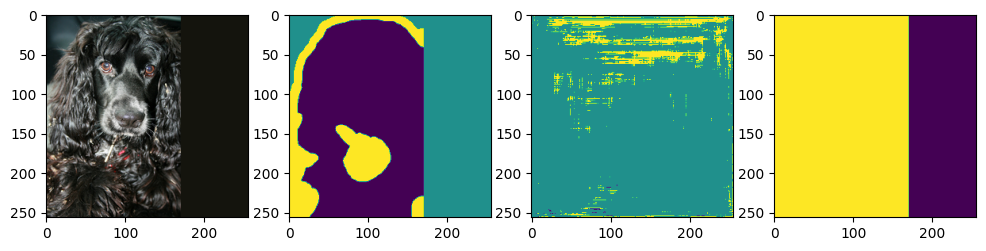

In [26]:
inference(img[0], label[0], mask[0], finetune_model, device)

# Fine-Tune on Semantic Segmentation




In [58]:
lr = 3e-4
save_step = 50
training_step = 10*500
warm_up = int(0.2*training_step)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(finetune_model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up ,num_training_steps=training_step)

model_name = 'upper'

loss_list = []
valid_loss_list = []
step = 0
stop = 0
best_loss = float('inf')

while True:

    for X in train_loader:

        img, label, mask = X[0].to(device), X[1].long().to(device), X[2].to(device)
        concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 

        finetune_model.train()
        output = finetune_model(concated)
        loss = criterion(output*(mask.unsqueeze(1)), (label*mask).long())
        loss_list.append(loss.item())
        print(f"step: {step+1}, loss: {loss.item():.8f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        step += 1

        if step % save_step == 0:
            
            print(40*'-')
            finetune_model.eval()
            total_loss = 0.0
            for X in valid_loader:
                img, label, mask = X[0].to(device), X[1].long().to(device), X[2].to(device)
                concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 
                with torch.no_grad():
                    output = finetune_model(concated)
                loss = criterion(output*(mask.unsqueeze(1)), (label*mask).long())
                total_loss += loss.item() * img.shape[0]
            valid_loss = total_loss/len(valid_loader.dataset)
            valid_loss_list.append(valid_loss)
            print(f'Averaged Train Loss: {np.mean(loss_list):.8f}, Validation Loss: {valid_loss:.8f}')
            
            inference(img[1], label[1], mask[1], finetune_model, device)

            if valid_loss < best_loss:
                model_state_dict = {'encoder': finetune_model.encoder.state_dict(),
                                    'decoder': finetune_model.decoder.state_dict(),
                                    'mask': finetune_model.segmentation_head.state_dict(),
                                    'optimizer': optimizer.state_dict(),
                                    'scheduler': scheduler.state_dict()}
                torch.save(model_state_dict, f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}.pth')
                print(f'Model checkpoint saved at step {step}')
                best_loss = valid_loss
            print(40*'-')

            if len(valid_loss_list) > 1:  
                if valid_loss < valid_loss_list[-2]:
                    stop = 0
                else:
                    stop += 1
                    if stop >= 3:   # stop training when no improvement in validation loss observed in 3 consecutive checkpoints
                        print('Early stopped at step: ', step)
                        break

        if step == training_step:
            break
            
    if step == training_step:
        break

np.save(f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}_loss.npy', np.array(loss_list))
np.save(f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}_valid_loss.npy', np.array(valid_loss_list))

Output hidden; open in https://colab.research.google.com to view.

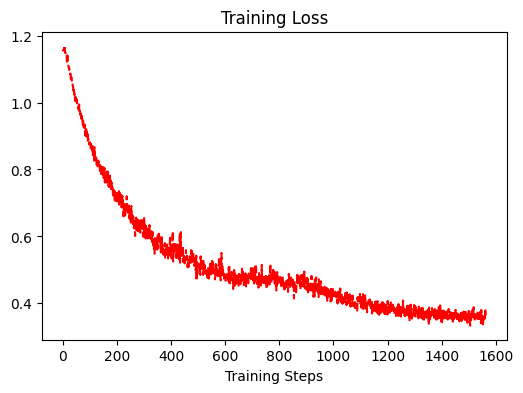

In [49]:
plt.figure(figsize=(6,4))
plt.plot(loss_list, 'r--')
plt.title('Training Loss')
plt.xlabel('Training Steps')
plt.show()

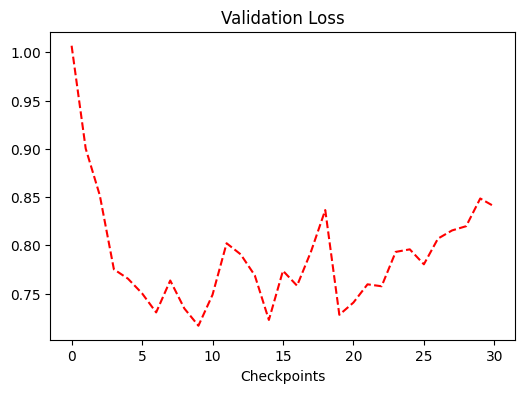

In [50]:
plt.figure(figsize=(6,4))
plt.plot(valid_loss_list, 'r--')
plt.title('Validation Loss')
plt.xlabel('Checkpoints')
plt.show()

In [51]:
min(valid_loss_list)

0.7166833732579205

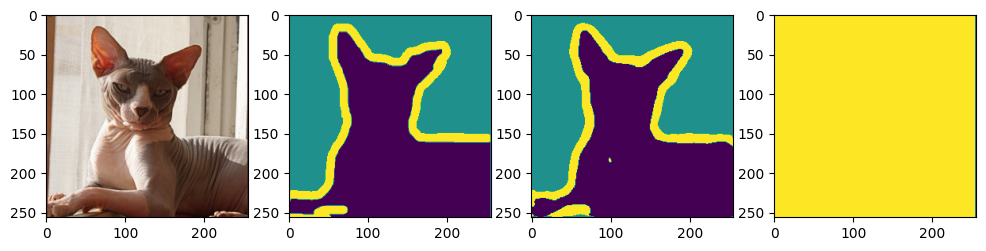

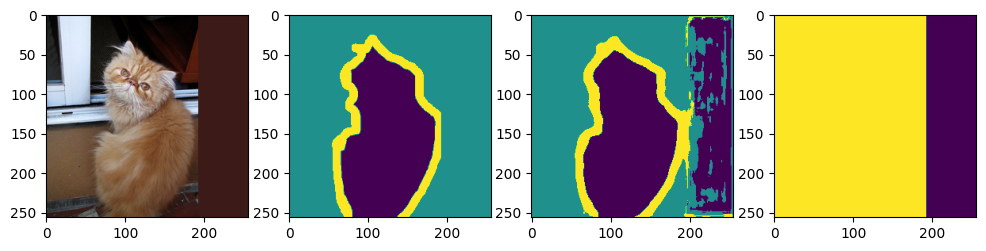

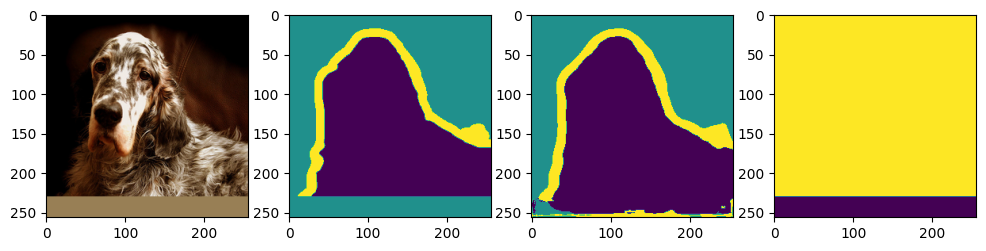

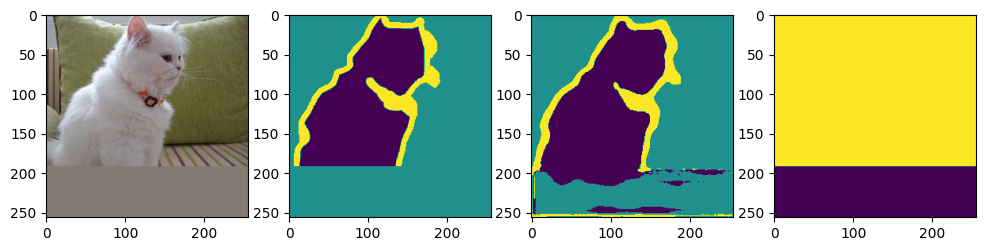

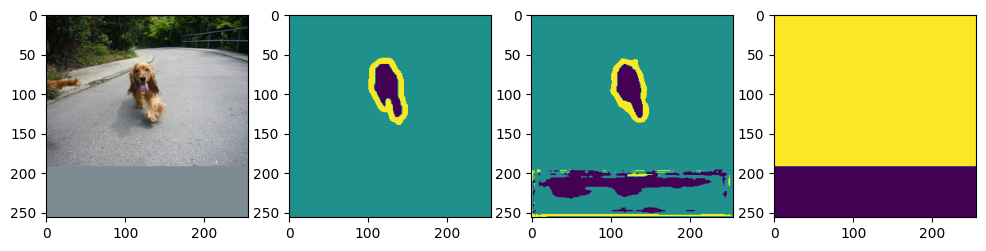

In [52]:
img, label, mask = next(iter(train_loader))

for i in range(5):
    i += 10
    inference(img[i], label[i], mask[i], finetune_model, device)

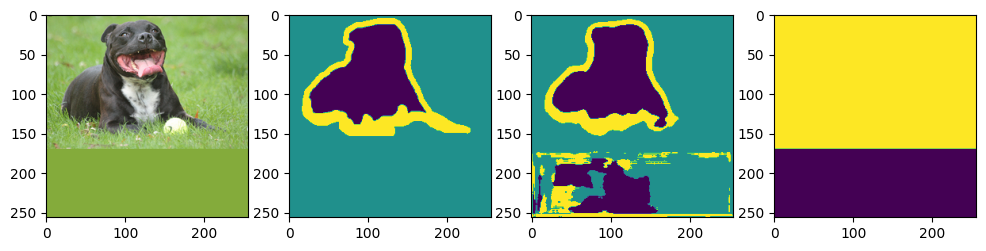

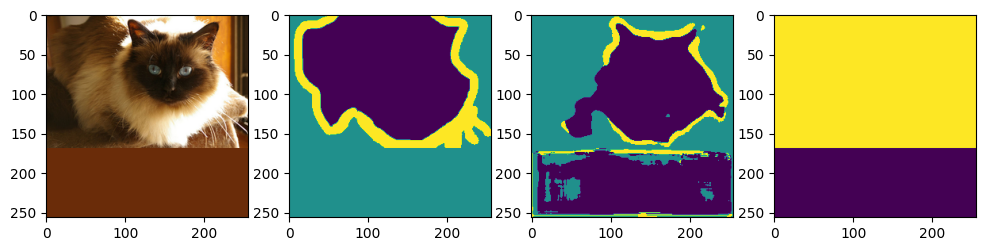

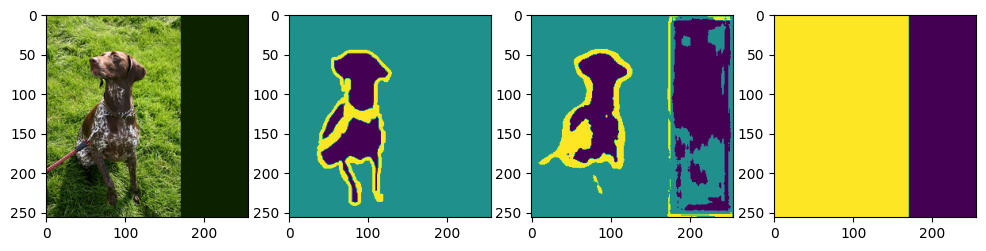

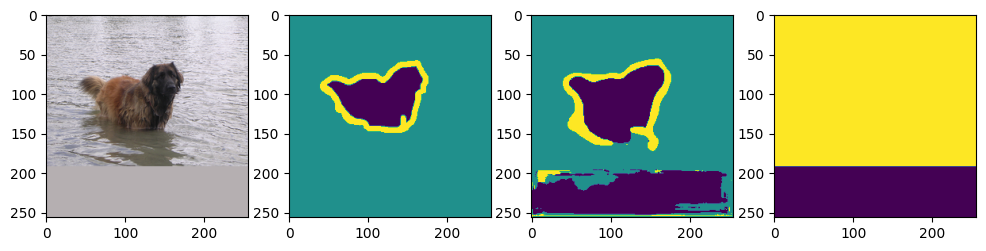

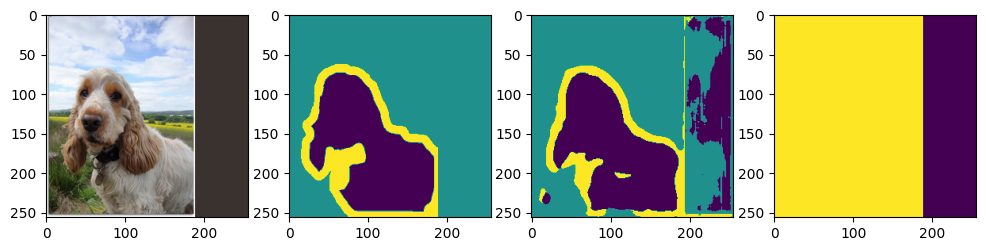

In [55]:
img, label, mask = next(iter(test_loader))

for i in range(5):
    i += 5
    inference(img[i], label[i], mask[i], finetune_model, device)